### Timing Study Visualization - for Supplementary Figure S1
Run the cells below in Julia 1.8 unless otherwise stated

In [2]:
home_path = "C:/Users/Charlotte/OneDrive - University of Edinburgh/Documents/research/joint-simulator/"

include(home_path * "models/glucaric_acid.jl")

# Import required package
using DifferentialEquations
using COBREXA
using DataFrames
using Tulip
using Plots
using Colors
using ModelingToolkit
using Statistics
using GLM
using Random
using Flux
using ProgressMeter
using MLBase #Confusion matrix function
using Serialization
using TreeParzen
using CSV
using LatinHypercubeSampling
println("Imports completed")


Imports completed


In [6]:
#Load in standard training data:
data = CSV.read("F:/medium_conditions/training_glucose.csv", DataFrame)

#Train ML models to predict feasibility
replace!(data.v_in, NaN => -1)
replace!(data.lam, NaN => -1)

#Separate data into training and test
Random.seed!(2023)
train_indices = randsubseq(1:size(data, 1), 0.8)
test_indices = setdiff(1:size(data, 1), train_indices)

train_data = data[train_indices, :]
test_data = data[test_indices, :]

#Train a logistic regression model
println("Classifying flux feasibility...")
feas_model = glm(@formula(feas~v_dp), train_data, Binomial(), LogitLink())

#Compute training accuracy
train_pred = predict(feas_model, train_data)
train_pred_class = ifelse.(train_pred .> 0.5, 1, 0)
accuracy = sum(train_pred_class .== train_data.feas) / length(train_data.feas)
println("Accuracy on training set: $accuracy")

#Generate predictions on test set 
test_pred = predict(feas_model, test_data)
test_pred_class = ifelse.(test_pred .> 0.5, 1, 0)
accuracy = sum(test_pred_class .== test_data.feas) / length(test_data.feas)
println("Accuracy on test set: $accuracy")

#Create and plot confusion matrix
cm = confusmat(2, train_data.feas.+ 1, train_pred_class.+ 1)
p1 = heatmap(cm, c=:blues, xlabel="Predicted", ylabel="True", title="Training Set", xticks=nothing, yticks=nothing, colorbar=false, legend=nothing)
annotate!([(i, j, text(cm[i, j])) for i in 1:size(cm)[1] for j in 1:size(cm)[2]])

cm = confusmat(2, test_data.feas.+ 1, test_pred_class.+ 1)
p2 = heatmap(cm, c=:blues, xlabel="Predicted", ylabel="True", title="Test Set", xticks=nothing, yticks=nothing, colorbar=false, legend=nothing)
annotate!([(i, j, text(cm[i, j])) for i in 1:size(cm)[1] for j in 1:size(cm)[2]])

plot(p1, p2, layout = (1, 2), dpi=300, size=(400, 220))

#Select only feasible data 
feas_train_indices = [findall(x -> x == 1, train_data.feas)] 
feas_train_data = train_data[feas_train_indices[1], :]
feas_test_indices = [findall(x -> x == 1, test_pred_class)] 
feas_test_data = test_data[feas_test_indices[1], :]

#Train a neural network model to predict v_in
println("Predicting pathway influx...")
num_epochs = 1000
step_size = 0.01
num_units = 500
#Create model architecture
v_in_model = Chain(Dense(1, num_units, relu), Dense(num_units, num_units, relu), Dense(num_units, 1))

#Transpose train and test data from DataFrame
x_train = feas_train_data.v_dp'
y_train = feas_train_data.v_in'
x_test = feas_test_data.v_dp'
y_test = feas_test_data.v_in'

#Define loss function and optimizer
loss(v_in_model, x, y) = mean(abs2.(v_in_model(x) .- y))
opt = Flux.setup(Adam(step_size), v_in_model)

#training loop
losses = []
for epoch in 1:num_epochs
    Flux.train!(loss, v_in_model, [(x_train, y_train)], opt)
    push!(losses, loss(v_in_model, x_train, y_train))
end

#Compute training loss
train_loss = losses[end]
println("Final training loss: $train_loss")

#Compute test loss
test_loss = loss(v_in_model, x_test, y_test)
println("Test loss: $test_loss")

#Train a linear model to predict lam
println("Predicting growth rate...")
lam_model = fit(LinearModel, @formula(lam~v_dp), feas_train_data)

#Compute training accuracy
train_pred = predict(lam_model, feas_train_data)
mse = (mean(feas_train_data.lam - train_pred).^2)
r2_model = r2(lam_model)
println("MSE on training set: $mse")
println("Model R^2: $r2_model")

#Compute test accuracy
test_pred = predict(lam_model, feas_test_data)
mse = (mean(feas_test_data.lam - test_pred).^2)
println("MSE on test set: $mse")

Classifying flux feasibility...
Accuracy on training set: 1.0
Accuracy on test set: 1.0
Predicting pathway influx...


┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(1 => 500, relu)
│   summary(x) = 1×367 adjoint(::Vector{Float64}) with eltype Float64
└ @ Flux C:\Users\Charlotte\.julia\packages\Flux\uCLgc\src\layers\stateless.jl:50


Final training loss: 7.55173370696956e-5
Test loss: 6.900496302228796e-5
Predicting growth rate...
MSE on training set: 2.6507269936868316e-32
Model R^2: 0.9999940868993147
MSE on test set: 9.814562595894043e-9


In [24]:
#FIGURE S1 - Machine learning results

#CONFUSION MATRIX
p1 = heatmap(cm, type="heatmap", color =:blues, xticks=[], yticks=[], xlabel="Infeasible          Feasible \n Predicted Label", ylabel="True Label \n Infeasible          Feasible", aspect_ratio=:equal, legend=:none, dpi=300)
#Annotate with numbers
for i in 1:size(cm, 1)
    for j in 1:size(cm, 2)
        annotate!(j, i, text(cm[i, j], :center, 10))
    end
end
plot(p1, layout=(1,1), size=(300,300))
# savefig("../figs/figs1a.png")

#LOSS PLOT
p2 = plot(losses, legend=:none, lw=3, xlabel="Neural Network\nTraining Epoch", ylabel="Training Loss", dpi=300)

plot(p2, layout=(1,1), size=(300,300))
savefig("../figs/figs1c.png")

# #GROUND TRUTH VS PREDICTION - v_in
# flux_data = DataFrame("v_dp" => feas_train_data.v_dp[1:25:end])
# pred_v_in = v_in_model(flux_data.v_dp')

# p3 = plot(feas_train_data.v_dp, feas_train_data.v_in, legend=:none, lw=3, xlabel="Dynamic Pathway Flux (mM/hr)", ylabel="Boundary Flux (mM/hr)", dpi=300)
# scatter!(feas_train_data.v_dp[1:25:end], pred_v_in', legend=:none)

# plot(p3, layout=(1,1), size=(300,300))
# savefig("../figs/figs1d.png")

# #GROUND TRUTH VS PREDICTION - lam
# p4 = plot(feas_train_data.v_dp, feas_train_data.lam, legend=:none, lw=3, xlabel="Dynamic Pathway Flux (mM/hr)", ylabel="Growth Rate(1/hr)", dpi=300)
# scatter!(feas_train_data.v_dp[1:50:end], train_pred[1:50:end], legend=:none)

# plot(p4, layout=(1,1), size=(300,300))
# savefig("../figs/figs1b.png")

"c:\\Users\\Charlotte\\OneDrive - University of Edinburgh\\Documents\\research\\joint-simulator\\figs\\figs1c.png"

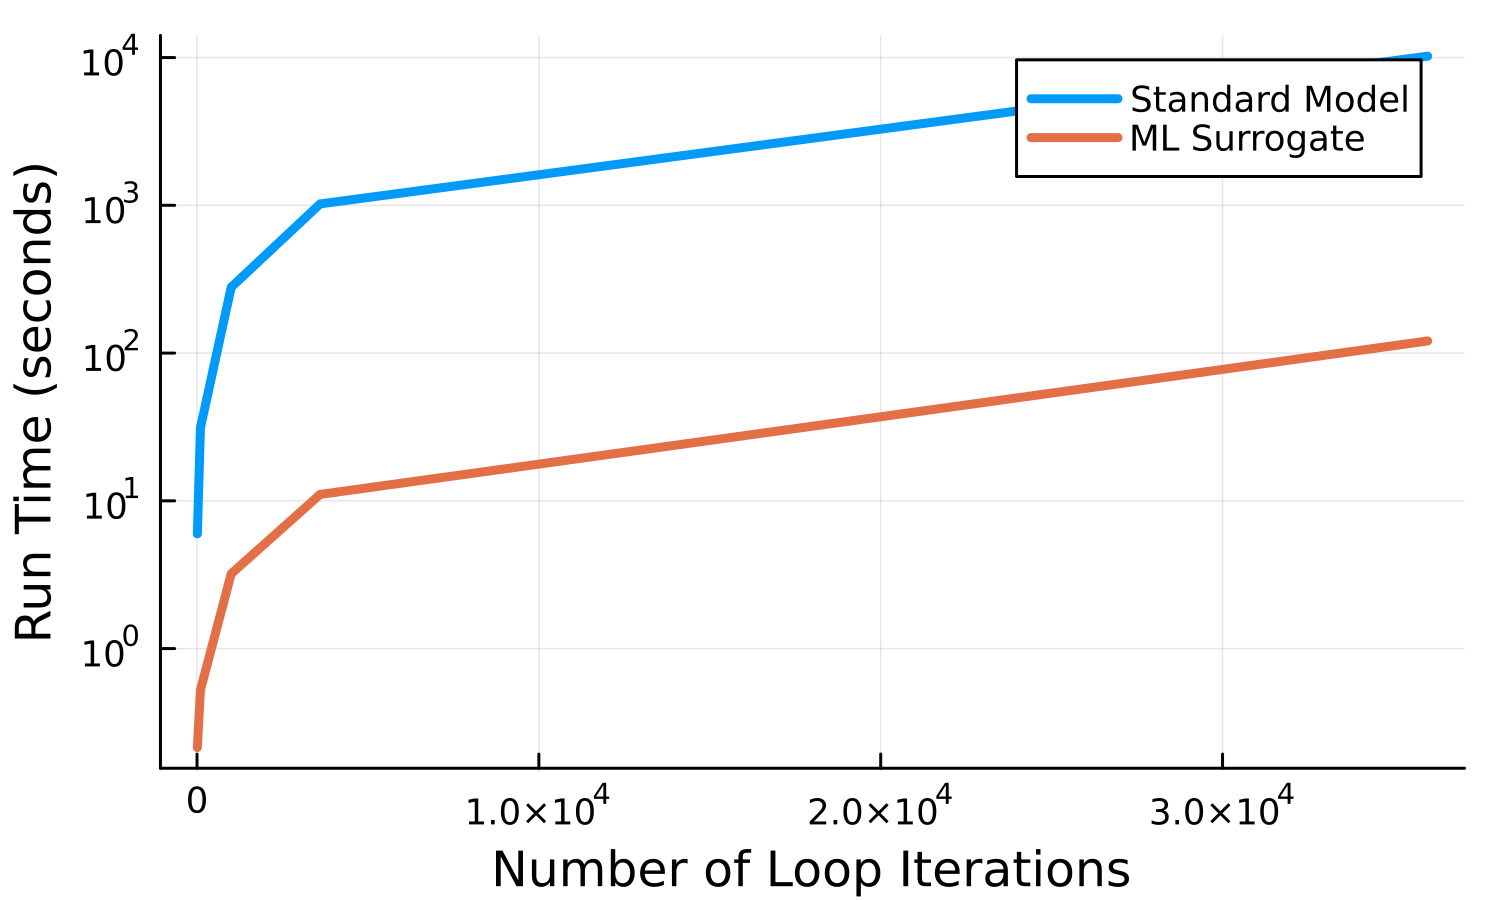

In [21]:
# FIGURE S2 - Timing study results - taken from table
timing = DataFrame("time"=> [10, 100, 1000, 3600, 36000], "standard" => [5.979702, 31.231, 279.028147, 1022.374149 , 1022*10], "surrogate" => [0.21405, 0.5244158, 3.21071, 11.0540, 120.788])

p = plot(timing.time, [timing.standard, timing.surrogate], lw=3, labels=["Standard Model" "ML Surrogate"], xlabel="Number of Loop Iterations", ylabel="Run Time (seconds)", dpi=300, yaxis=:log)
plot(p, size=(500, 300))
savefig("../figs/suppfig2.png")